In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from scipy import ndimage

import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.modeling import models, fitting, Fittable2DModel, Parameter
from ccdproc import CCDData, combine, Combiner, flat_correct, trim_image

I'm going to be fitting a model to the alignment box image.  This model will be the alignment box itself, plus a single 2D gaussian star.  The following class is an `astropy.models` model of the trapezoidal shape of the MOSFIRE alignment box.

In [2]:
class mosfireAlignmentBox(Fittable2DModel):
    amplitude = Parameter(default=1)
    x_0 = Parameter(default=0)
    y_0 = Parameter(default=0)
    x_width = Parameter(default=1)
    y_width = Parameter(default=1)

    @staticmethod
    def evaluate(x, y, amplitude, x_0, y_0, x_width, y_width):
        '''MOSFIRE Alignment Box.
        
        Typical widths are 22.5 pix horizontally and 36.0 pix vertically.
        
        Angle of slit relative to pixels is 3.78 degrees.
        '''
        slit_angle = -3.7 # in degrees
        x0_of_y = x_0 + (y-y_0)*np.sin(slit_angle*np.pi/180)
        
        x_range = np.logical_and(x >= x0_of_y - x_width / 2.,
                                 x <= x0_of_y + x_width / 2.)
        y_range = np.logical_and(y >= y_0 - y_width / 2.,
                                 y <= y_0 + y_width / 2.)
        result = np.select([np.logical_and(x_range, y_range)], [amplitude], 0)

        if isinstance(amplitude, u.Quantity):
            return Quantity(result, unit=amplitude.unit, copy=False)
        else:
            return result

    @property
    def input_units(self):
        if self.x_0.unit is None:
            return None
        else:
            return {'x': self.x_0.unit,
                    'y': self.y_0.unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        return OrderedDict([('x_0', inputs_unit['x']),
                            ('y_0', inputs_unit['y']),
                            ('x_width', inputs_unit['x']),
                            ('y_width', inputs_unit['y']),
                            ('amplitude', outputs_unit['z'])])

This is a simple helper function which I stole from my `CSU_initializer` project.  It may not be necessary as I am effectively fitting the location of the alignment box twice.

In [3]:
def fit_edges(profile):
    fitter = fitting.LevMarLSQFitter()

    amp1_est = profile[profile == min(profile)][0]
    mean1_est = np.argmin(profile)
    amp2_est = profile[profile == max(profile)][0]
    mean2_est = np.argmax(profile)
    
    g_init1 = models.Gaussian1D(amplitude=amp1_est, mean=mean1_est, stddev=2.)
    g_init1.amplitude.max = 0
    g_init1.amplitude.min = amp1_est*0.9
    g_init1.stddev.max = 3
    g_init2 = models.Gaussian1D(amplitude=amp2_est, mean=mean2_est, stddev=2.)
    g_init2.amplitude.min = 0
    g_init2.amplitude.min = amp2_est*0.9
    g_init2.stddev.max = 3

    model = g_init1 + g_init2
    fit = fitter(model, range(0,horizontal_profile.shape[0]), horizontal_profile)
    
    # Check Validity of Fit
    if abs(fit.stddev_0.value) <= 3 and abs(fit.stddev_1.value) <= 3\
       and fit.amplitude_0.value < -1 and fit.amplitude_1.value > 1\
       and fit.mean_0.value > fit.mean_1.value:
        x1 = fit.mean_0.value
        x2 = fit.mean_1.value
    else:
        x1 = None
        x2 = None

    return x1, x2

## Create Master Flat

Rather than take time to obtain a sky frame for each mask alignment, I am going to treat the sky background as a constant over the alignment box area (roughly 4 x 7 arcsec).  To do that, I need to flat field the image.

Note that this flat field is built using data from a different night than the alignment box image we will be processing.

In [4]:
filepath = '../../../KeckData/MOSFIRE_FCS/'
dark = CCDData.read(os.path.join(filepath, 'm180130_0001.fits'), unit='adu')

flatfiles = ['m180130_0320.fits',
             'm180130_0321.fits',
             'm180130_0322.fits',
             'm180130_0323.fits',
             'm180130_0324.fits',
            ]
flats = []
for i,file in enumerate(flatfiles):
    flat = CCDData.read(os.path.join(filepath, file), unit='adu')
    flat = flat.subtract(dark)
    flats.append(flat)

INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]


In [5]:
flat_combiner = Combiner(flats)
flat_combiner.sigma_clipping()
scaling_func = lambda arr: 1/np.ma.average(arr)
flat_combiner.scaling = scaling_func
masterflat = flat_combiner.median_combine()

# masterflat.write('masterflat.fits', overwrite=True)

## Reduce Alignment Image

In [6]:
# align1 = CCDData.read(os.path.join(filepath, 'm180130_0052.fits'), unit='adu')
align1 = CCDData.read(os.path.join(filepath, 'm180210_0254.fits'), unit='adu')
align1ds = align1.subtract(dark)
align1f = flat_correct(align1ds, masterflat)

INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/jwalawender/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)
/Users/jwalawender/anaconda/lib/python3.6/site-packages/astropy/nddata/nduncertainty.py:606: RuntimeWarning: divide by zero encountered in true_divide
  right = (other_uncert.array / other_uncert.parent_nddata.data)


## Find Alignment Box and Star

For now, I am manually entering the rough location of the alignment box within the CCD.  This should be read from header.

In [7]:
# box_loc = (1257, 432) # for m180130_0052
# box_loc = (1544, 967) # for m180210_0254
# box_loc = (821, 1585) # for m180210_0254
# box_loc = (1373, 1896) # for m180210_0254
box_loc = (791, 921) # for m180210_0254
# box_loc = (1268, 301) # for m180210_0254


box_size = 30
fits_section = f'[{box_loc[0]-box_size:d}:{box_loc[0]+box_size:d}, {box_loc[1]-box_size:d}:{box_loc[1]+box_size:d}]'
print(fits_section)
region = trim_image(align1f, fits_section=fits_section)

[761:821, 891:951]


The code below estimates the center of the alignment box

In [8]:
threshold_pct = 70
window = region.data > np.percentile(region.data, threshold_pct)
alignment_box_position = ndimage.measurements.center_of_mass(window)

The code below finds the edges of the box and measures its width and height.

In [9]:
gradx = np.gradient(region.data, axis=1)
horizontal_profile = np.sum(gradx, axis=0)
grady = np.gradient(region.data, axis=0)
vertical_profile = np.sum(grady, axis=1)

In [10]:
h_edges = fit_edges(horizontal_profile)
print(h_edges, h_edges[0]-h_edges[1])

(41.80651658596468, 19.994705691583249) 21.8118108944


In [11]:
v_edges = fit_edges(vertical_profile)
print(v_edges, v_edges[0]-v_edges[1])

(47.371693621584278, 11.626902032060636) 35.7447915895


This code estimates the initial location of the star.  The fit to the star is quite rudimentary and could be replaced by more sophisticated methods.

In [12]:
maxr = region.data.max()
starloc = (np.where(region.data == maxr)[0][0], np.where(region.data == maxr)[1][0])

### Build Model for Box + Star

Build an `astropy.models` model of the alignment box **and** star and fit the compound model to the data.

In [13]:
boxamplitude = 1 #np.percentile(region.data, 90)
star_amplitude = region.data.max() - boxamplitude

box = mosfireAlignmentBox(boxamplitude, alignment_box_position[1], alignment_box_position[0],\
                   abs(h_edges[0]-h_edges[1]), abs(v_edges[0]-v_edges[1]))
box.amplitude.fixed = True

star = models.Gaussian2D(star_amplitude, starloc[0], starloc[1])
star.amplitude.min = 0
star.x_stddev.min = 1
star.x_stddev.max = 8
star.y_stddev.min = 1
star.y_stddev.max = 8

sky = models.Const2D(np.percentile(region.data, 90))
sky.amplitude.min = 0

model = box*(sky + star)

In [14]:
fitter = fitting.LevMarLSQFitter()
y, x = np.mgrid[:2*box_size+1, :2*box_size+1]
fit = fitter(model, x, y, region.data)
print(fitter.fit_info['message'])

Number of calls to function has reached maxfev = 100.


In [15]:
# Do stupid way of generating an image from the model for visualization (replace this later)
modelim = np.zeros((61,61))
fitim = np.zeros((61,61))
for i in range(0,60):
    for j in range(0,60):
        modelim[j,i] = model(i,j)
        fitim[j,i] = fit(i,j)
resid = region.data-fitim

In [16]:
for i,name in enumerate(fit.param_names):
    print(f"{name:15s} = {fit.parameters[i]:.2f}")

amplitude_0     = 1.00
x_0_0           = 30.97
y_0_0           = 29.18
x_width_0       = 21.81
y_width_0       = 35.74
amplitude_1     = 3438.16
amplitude_2     = 1040.88
x_mean_2        = 23.48
y_mean_2        = 23.88
x_stddev_2      = 2.34
y_stddev_2      = 1.70
theta_2         = 11.29


## Results

The cell below, shows the image, the initial model guess, the fitted model, and the difference between the data and the model.

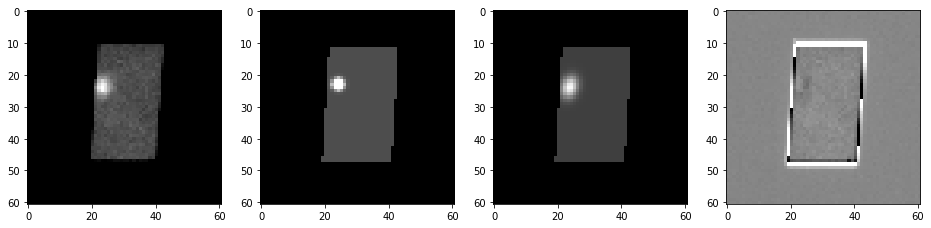

In [17]:
plt.figure(figsize=(16,24))
plt.subplot(1,4,1)
plt.imshow(region.data, vmin=fit.amplitude_1.value*0.9, vmax=fit.amplitude_1.value+fit.amplitude_2.value)
plt.subplot(1,4,2)
plt.imshow(modelim, vmin=fit.amplitude_1.value*0.9, vmax=fit.amplitude_1.value+fit.amplitude_2.value)
plt.subplot(1,4,3)
plt.imshow(fitim, vmin=fit.amplitude_1.value*0.9, vmax=fit.amplitude_1.value+fit.amplitude_2.value)
plt.subplot(1,4,4)
plt.imshow(resid, vmin=-1000, vmax=1000)
plt.show()

## Results

Show the image with an overlay marking the determined center of the alignment box and the position of the star.

Please note that this code fits the location of the box and so it can **confirm** the FCS operation has placed the box in a consistent location when checked against the header.

It should also be able to message and automatically respond if the star is not found or is very faint (i.e. it has lower than expected flux).

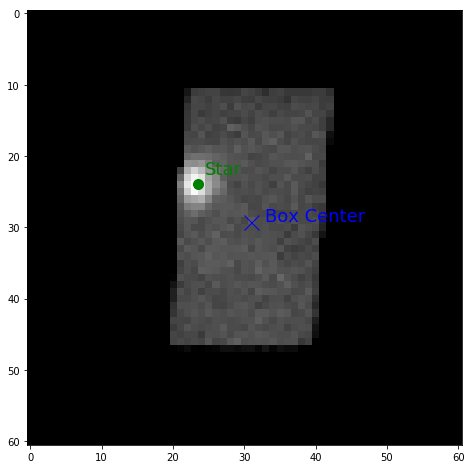

Sky Brightness = 3438 ADU
Box X Center = 31.0
Box Y Center = 29.2
Stellar FWHM = 0.87 arcsec
Stellar Xpos = 23.5
Stellar Xpos = 23.9
Stellar Amplitude = 1041 ADU
Stellar Flux (fit) = 26023 ADU


In [18]:
pixelscale = u.pixel_scale(0.1798*u.arcsec/u.pixel)
FWHMx = 2*(2*np.log(2))**0.5*fit.x_stddev_2 * u.pix
FWHMy = 2*(2*np.log(2))**0.5*fit.y_stddev_2 * u.pix
FWHM = (FWHMx**2 + FWHMy**2)**0.5/2**0.5
stellar_flux = 2*np.pi*fit.amplitude_2.value*fit.x_stddev_2.value*fit.y_stddev_2.value

plt.figure(figsize=(8,8))
plt.imshow(region.data, vmin=fit.amplitude_1.value*0.9, vmax=fit.amplitude_1.value+fit.amplitude_2.value)
plt.plot([fit.x_mean_2.value], [fit.y_mean_2.value], 'go', ms=10)
plt.text(fit.x_mean_2.value+1, fit.x_mean_2.value-1, 'Star', color='green', fontsize=18)
plt.plot([fit.x_0_0.value], [fit.y_0_0.value], 'bx', ms=15)
plt.text(fit.x_0_0.value+2, fit.y_0_0.value, 'Box Center', color='blue', fontsize=18)
plt.show()

print(f"Sky Brightness = {fit.amplitude_1.value:.0f} ADU")
print(f"Box X Center = {fit.x_0_0.value:.1f}")
print(f"Box Y Center = {fit.y_0_0.value:.1f}")
print(f"Stellar FWHM = {FWHM.to(u.arcsec, equivalencies=pixelscale):.2f}")
print(f"Stellar Xpos = {fit.x_mean_2.value:.1f}")
print(f"Stellar Xpos = {fit.y_mean_2.value:.1f}")
print(f"Stellar Amplitude = {fit.amplitude_2.value:.0f} ADU")
print(f"Stellar Flux (fit) = {stellar_flux:.0f} ADU")